In [1]:
__author__ = 'Vinicius Placco <vinicius.placco@noirlab.edu>, Brian Molina Merino <brian.merino@noirlab.edu>'
__version__ = '20230821' # yyyymmdd
__keywords__ = ['IRAF', 'Gemini', 'GMOS', 'data reduction']

# Gemini GMOS Longslit Spectroscopy data reduction using Pyraf
*Authors: Brian Molina Merino, Vinicius Placco*

*Adapted from https://gitlab.com/nsf-noirlab/csdc/usngo/IRAF_tutorials*

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Downloading data for reduction](#download)
* [Begin Basic Reduction](#Basic_Reduction)
* [Determine Wavelength Solution](#Wavelength_Solution)
* [Extract Spectrum](#Extract_Spectrum)
* [Display Output](#Display_Output)
* [Clean-up (optional)](#Clean-up)
* [Resources](#Resources)

<a class="anchor" id="goals"></a>
# Goals
Showcase how to perform GMOS longslit spectroscopy data reduction using the Gemini Pyraf package on the Data Lab science platform. The steps include downloading data from the Gemini archive, processing of flat and bias frames, and finally the creation of a single wavelength-calibrated 1D spectrum. For simplicity, there is no flux calibration in this example.

<a class="anchor" id="summary"></a>
# Summary
In this notebook, we present an example of a Gemini GMOS notebook that works in the Data Lab environment to fully reduce GMOS longslit B600 spectroscopy data. This is a version of the GMOS longslit Hamamatsu reduction tutorial presented here:
https://gitlab.com/nsf-noirlab/csdc/usngo/IRAF_tutorials.
The general GMOS data reduction cookbook from the US National Gemini Office is linked here:
https://noirlab.edu/science/programs/csdc/usngo/gmos-cookbook/. The object in this example is the standard star <a href="http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD166379">HD166379</a>, observed as part of the Gemini North program <a href="https://archive.gemini.edu/searchform/GN-2018B-Q-403-54">GN-2018B-Q-54</a>. The exposure time was 5 seconds, with the flat-field and CuAr arc-lamp taken right after the science observation.

<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

* NOIRLab acknowledgment page for the use of data from the Gemini Observatory: https://noirlab.edu/science/about/scientific-acknowledgments#gemini

<a class="anchor" id="imports"></a>
# Imports and setup

In [2]:
from pyraf import iraf
from pyraf.iraf import gemini, gmos
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np


No graphics display available for this session.
Graphics tasks that attempt to plot to an interactive screen will fail.
For help, search "PyRAF FAQ 5.13" or contact "help@stsci.edu".



<a class="anchor" id="download"></a>
# Downloading data from the Gemini archive

Create a list of the file names of the raw GMOS longslit B600 spectroscopy data, and use wget to download these from the Gemini archive. The dataset includes bias, flat-field, arc-lamp, and one science exposure.

In [3]:
%%bash

# create file that lists FITS files to be downloaded
echo "
https://archive.gemini.edu/file/N20190302S0248.fits
https://archive.gemini.edu/file/N20190302S0249.fits
https://archive.gemini.edu/file/N20190302S0250.fits
https://archive.gemini.edu/file/N20190304S0204_bias.fits" > gmos.list

# download with wget FITS files from Gemini archive for processing (in quiet mode)
wget --no-check-certificate -N -q -i gmos.list

<a class="anchor" id="Basic_Reduction"></a>
# Basic Reduction

Basic reduction (including bias subtraction) of the science, arc, and flat frames. The second to last step generates the final flat field and applies it to the science frame. In the first three commands, the raw frames run through `gsreduce` for mosaicing (`fl_gmosaic="Yes"`) without flat-fielding, trimming, bax pixel masking, or wavelength solution (`fl_flat="No"`, `fl_fixpix="No"`, `fl_gsappwave="No"`, `fl_cut="No"`). The fourth command creates the final flat field and the last command applies it to the science frame.

*Note: during the data reduction in the next three cells, a number of temporary files (starting with `tmp`) will be created and deleted. In addition, after each reduction step, a `fits` file is created using the name of the original file with a 1-letter prefix (e.g. `sN20190302S0250`). Single letters will continue to be added until the final extracted spectrum is generated. This cell will take a few minutes to execute.*

In [4]:
gmos.gsreduce(inimages="N20190302S0248", 
              fl_flat="No", fl_gmosaic="Yes", fl_fixpix="No", fl_gsappwave="No", 
              fl_cut="No", bias="N20190304S0204_bias")

gmos.gsreduce(inimages="N20190302S0249", rawpath="./", 
              fl_flat="No", fl_gmosaic="Yes", fl_fixpix="No", fl_gsappwave="No", 
              fl_cut="No", bias="N20190304S0204_bias")

gmos.gsreduce(inimages="N20190302S0250", rawpath="./", 
              fl_flat="No", fl_gmosaic="Yes", fl_fixpix="No", fl_gsappwave="No", 
              fl_cut="No", bias="N20190304S0204_bias")

gmos.gsflat(inflats="gsN20190302S0250", specflat="N20190302S0250_flat",
            order="23", fl_over="Yes")

gmos.gsreduce(inimages="gsN20190302S0248", flat="N20190302S0250_flat",
              fl_over="No", fl_bias="No", fl_trim="No")


----------------------------------------------------------------------------
GSREDUCE -- Mon 14:52:45 21-Aug-2023

Input image or list  = N20190302S0248
Output image or list = 
Output prefix        = gs

Overscan subtraction  fl_over      = yes
Trim image            fl_trim      = yes
Bias subtraction      fl_bias      = yes
Cosmic ray cleaning   fl_gscrrej   = no
New CR cleaning       fl_crspec    = no
Dark subtraction      fl_dark      = no
QE Correction         fl_qecorr    = no
Flat field correction fl_flat      = no
Mosaic the CCDs       fl_gmosaic   = yes
Fixpix chip gaps      fl_fixpix    = no
Cut MOS spectra       fl_cut       = no
Add titles to MOS     fl_title     = yes
Oversize slit length  fl_oversize  = yes
Run gsappwave         fl_gsappwave = no
Run gsscatsub         fl_scatsub   = no
VAR & DQ planes       fl_vardq     = no

geointer = linear
gradimage= 
refimage = 
bias     = N20190304S0204_bias
dark     = 
qe_refim    = 
qe_corrim   = 
qe_corrpref = qecorr
flatim   = 


<a class="anchor" id="Wavelength_Solution"></a>
# Determine Wavelength Solution

Non-interactively (`fl_inte="no"`) determine the wavelength solution and apply it to the arc lamp frame.

In [5]:
gmos.gswavelength(inimages="gsN20190302S0249", fl_inte="no")
gmos.gstransform(inimages="gsN20190302S0249", wavtraname="gsN20190302S0249")

--------------------------------------------------------------------------------
GSWAVELENGTH -- Mon 14:53:53 21-Aug-2023
 
inimages = gsN20190302S0249
--------------------------------------------------------------------------------
GSAPPWAVE -- Mon 14:53:53 21-Aug-2023
 
inimages = gsN20190302S0249.fits
Grating: B600+_G5307
Grating central wavelength: 420.0 [nm]
Resolution (0.5'' slit): 1530.15477728
Anamorphic factor: 1.14009149926
Grating tilt (header): 57.0085
Calculated tilt: 57.009
nm/pix = 0.101015300804
Filter1: open1-6
Filter2: open2-8
Approximate available wavelength coverage based on grating,
    filters and detector type is: 300.0 - 1080.0 [nm]

Calibrating: [SCI,1]
    Spectrum length in pixels: 3138
    Approximate location of grating central 
        wavelength in pixels: 1569.0
    Approximate wavelength coverage based on
        spectrum length and calculated dispersion is:  300 - 1080 [nm]
 
GSAPPWAVE done
--------------------------------------------------------------

<a class="anchor" id="Extract_Spectrum"></a>
# Extract Spectrum

Apply the wavelength solution to the science frame, perform sky-subtraction, and extract the stellar spectrum in non-interactive (`fl_inte="no"`) mode.

In [6]:
gmos.gstransform(inimages="gsgsN20190302S0248", wavtran="gsN20190302S0249")
gmos.gsskysub(input="tgsgsN20190302S0248")
gmos.gsextract(inimages="stgsgsN20190302S0248", fl_inte="no")

-------------------------------------------------------------------------------
GSTRANSFORM -- Mon 14:53:56 21-Aug-2023
 

inimages   = gsgsN20190302S0248
outimages  = 
outprefix  = t
fl_stran   = no
fl_wavtran = yes
wavtraname = gsN20190302S0249
database   = database
fl_vardq   = no
interptype = linear
lambda1    = INDEF
lambda2    = INDEF
dx         = INDEF
nx         = INDEF
lambdalog  = no
ylog       = no
fl_flux    = yes
gratingdb  = gmos$data/GMOSgratings.dat
filterdb   = gmos$data/GMOSfilters.dat
key_dispaxis = DISPAXIS
dispaxis   = 1
sci_ext    = SCI

Transforming gsgsN20190302S0248.fits[SCI,1]
MDF row: 1

NOAO/IRAF V2.16 @gp12.datalab.noirlab.edu Mon 14:53:56 21-Aug-2023
  Transform gsgsN20190302S0248.fits[SCI,1] to tmpsci35396_196.
  Conserve flux per pixel.
  User coordinate transformations:
    gsN20190302S0249_001
  Interpolation is linear.
  Using edge extension for out of bounds pixel values.
  Output coordinate parameters are:
    x1 =      2652., x2 =      5809., dx = 

<a class="anchor" id="Display_Output"></a>
# Display the fully reduced spectrum

Read the reduced spectrum with astropy, creating arrays for the flux and wavelength. The `wave` array is generated by getting the number of pixels in the `flux` array and using the wavelength values for the first pixel (`CRVAL1`) and wavelength step (`CD1_1`).

In [7]:
iraf_out = fits.open("estgsgsN20190302S0248.fits")

flux = iraf_out[2].data
wave = np.arange(flux.shape[0]) * iraf_out[2].header['CD1_1'] + iraf_out[2].header['CRVAL1']

Display the spectrum using standard matplotlib.pyplot routines.

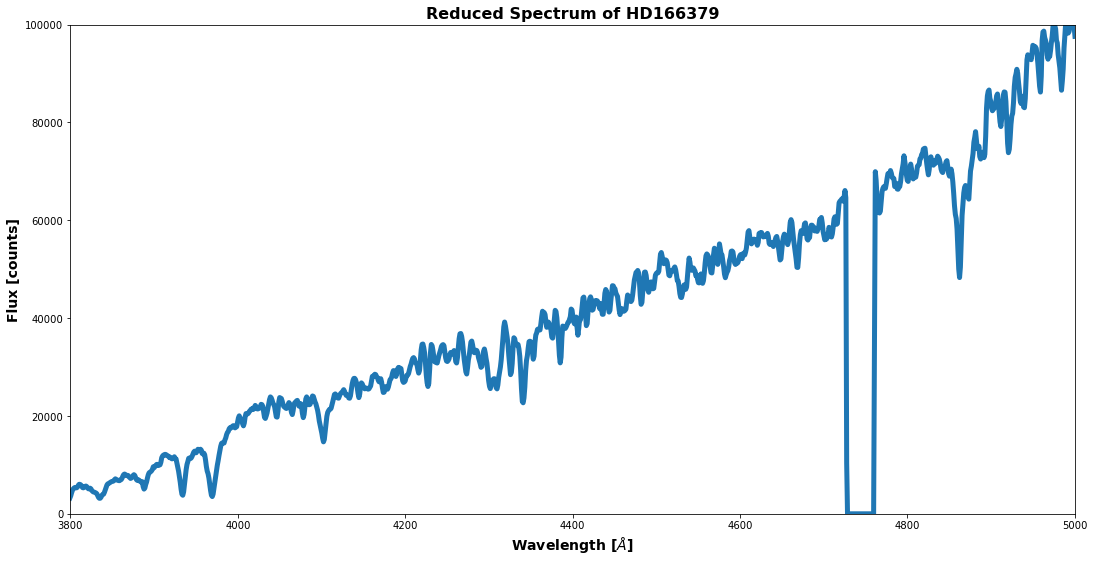

In [8]:
plt.figure(figsize = (18,9))
plt.xlim(3800,5000)
plt.ylim(0,100000)
plt.plot(wave,flux, linewidth=5)
plt.xlabel('Wavelength [$\AA$]',fontsize=14,fontweight='bold')
plt.ylabel('Flux [counts]',fontsize=14,fontweight='bold')
plt.title('Reduced Spectrum of HD166379',fontsize=16,fontweight='bold')
plt.show()

<a class="anchor" id="Clean-up"></a>
# Clean-up (optional)

Erase all fits files, lists, logs, and database created during the reduction. For that, uncomment the line below and execute. (This is necessary for instance if you wish to re-run the notebook, since some of the files produced can not be overwritten with Gemini IRAF.)

In [9]:
#!rm -f *N2019030*.fits Afx*.fits gmos.list gmos.log _sed tmp* # remove files
#!rm -rf database/ # remove directories

<a class="anchor" id="Resources"></a>
# Resources

US NGO GMOS Reduction Cookbook: https://noirlab.edu/science/programs/csdc/usngo/gmos-cookbook/

GMOS longslit Hamamatsu reduction tutorial: https://gitlab.com/nsf-noirlab/csdc/usngo/IRAF_tutorials